In [1]:
from landslide4sense.data import LandslideDataSet
from landslide4sense.utils.tools import eval_image
from landslide4sense.models import Unet
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import omegaconf
import matplotlib.pyplot as plt
from torch.nn import Upsample, CrossEntropyLoss

In [2]:
cfg = omegaconf.OmegaConf.load("../conf/config.yaml")
cfg

{'data': {'dir': '${hydra:runtime.cwd}/data/', 'train_list': '${hydra:runtime.cwd}/data/train_split_train.txt', 'eval_lists_paths': ['${hydra:runtime.cwd}/data/train_split_train.txt', '${hydra:runtime.cwd}/data/train_split_val.txt'], 'eval_names': ['train', 'val'], 'test_list': '${hydra:runtime.cwd}/data/valid.txt', 'input_size': [128, 128], 'augmentation': {'module': 'landslide4sense.data.augmentations', 'name': 'transforms'}}, 'model': {'restore_from': '/content/drive/MyDrive/data_science_projects/landslide4sense-2022/models/misunderstood-sound-36/epoch_5_val_f1=72.615/model.pth', 'module': 'segmentation_models_pytorch', 'name': 'UnetPlusPlus', 'args': {'in_channels': 14, 'classes': 2}}, 'optimizer': {'restore_from': '/content/drive/MyDrive/data_science_projects/landslide4sense-2022/models/misunderstood-sound-36/epoch_5_val_f1=72.615/optimizer.pt', 'module': 'torch.optim', 'name': 'Adam', 'args': {'lr': 0.001, 'weight_decay': 0.0005}}, 'loss': {'module': 'torch.nn', 'name': 'CrossEnt

In [3]:
train_dataset = LandslideDataSet(
    "../data/",
    "../data/train_split_train.txt",
    max_iters=cfg.train.num_steps_stop * cfg.train.batch_size,
    set="labeled",
)

In [4]:
train_loader: DataLoader[LandslideDataSet] = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=cfg.train.num_workers,
    pin_memory=True,
)

In [5]:
eval_set = LandslideDataSet("../data/", "../data/train_split_val.txt", set="labeled")

eval_loader: DataLoader[LandslideDataSet] = DataLoader(
    eval_set,
    batch_size=16,
    shuffle=False,
    num_workers=cfg.train.num_workers,
    pin_memory=True,
)

In [6]:
for batch in eval_loader:
    image, label, _, name = batch
    print(image.size())

torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([16, 14, 128, 128])
torch.Size([12, 14, 128, 128])


# Baseline Unet

In [16]:
model = Unet(n_classes=2)
model.train()

Unet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(14, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momen

In [17]:
batch = next(iter(train_loader))
images, labels, _, _ = batch
labels = labels.long()
pred = model(images)
print(pred.size())
pred = pred[:, 1]

torch.Size([4, 2, 128, 128])


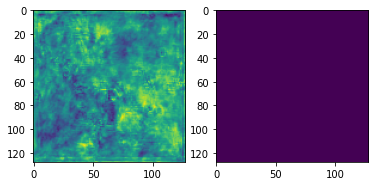

In [18]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(pred.detach().numpy()[0, ...])
ax[1].imshow(labels.detach().numpy()[0, ...])
plt.show()

In [19]:
labels.size()

torch.Size([4, 128, 128])

In [20]:
dice_loss = smp.losses.DiceLoss(mode="multiclass", ignore_index=255)
ce_loss = CrossEntropyLoss(ignore_index=255)

In [21]:
dice_loss(pred, labels)

RuntimeError: The size of tensor a (128) must match the size of tensor b (16384) at non-singleton dimension 2

# Unet++

In [34]:
model_pp = smp.UnetPlusPlus(in_channels=14, classes=2)

In [35]:
pred = model_pp(images)

In [36]:
pred.size()

torch.Size([4, 2, 128, 128])

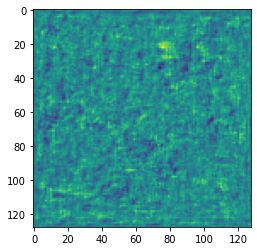

In [37]:
plt.imshow(pred[0, 1, ...].detach().numpy())

In [38]:
labels.size()

torch.Size([4, 128, 128])

In [39]:
pred.size()

torch.Size([4, 2, 128, 128])

In [40]:
dice_loss(pred, labels)

tensor(0.6246, grad_fn=<MeanBackward0>)